## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

# Set visual style
sns.set_theme(style="whitegrid")
%matplotlib inline

## Helper Functions

In [7]:
def stepwise_selection(X, y, threshold_in=0.01, threshold_out=0.05):
    """
    Perform Forward-Backward Stepwise Selection based on p-values.
    """
    X = X.astype(float) # Ensure X is float
    y = y.astype(float) # Ensure y is float
    included = []
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_col in excluded:
            # Add constant and cast to float
            cols = included + [new_col]
            model = sm.OLS(y, sm.add_constant(X[cols])).fit()
            new_pval[new_col] = model.pvalues[new_col]
        
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
        
        if included:
            model = sm.OLS(y, sm.add_constant(X[included])).fit()
            pvalues = model.pvalues.iloc[1:] 
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                changed = True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
        if not changed:
            break
    return included

def run_full_analysis(df, target_col, dataset_name):
    print(f"\n{'#'*30}\nANALYSIS: {dataset_name}\n{'#'*30}")
    
    # CRITICAL FIX: Ensure entire dataframe is numeric float before processing
    df = df.astype(float)
    
    # --- EDA ---
    plt.figure(figsize=(10, 4))
    sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
    plt.title(f"Correlation Heatmap: {dataset_name}")
    plt.show()

    # --- Feature Selection ---
    X_raw = df.drop(columns=[target_col])
    y = df[target_col]
    
    selected_features = stepwise_selection(X_raw, y)
    print(f"Selected Features: {selected_features}")
    X_selected = sm.add_constant(df[selected_features])

    # --- 1. In-Sample Quality of Fit ---
    model_in = sm.OLS(y, X_selected).fit()
    print("\n--- Statistical Summary (In-Sample) ---")
    print(model_in.summary().tables[1])
    print(f"In-Sample R-squared: {model_in.rsquared:.4f}")

    # --- 2. Validation (80-20 Split) ---
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model_val = sm.OLS(y_train, X_train).fit()
    y_pred = model_val.predict(X_test)
    val_r2 = r2_score(y_test, y_pred)
    print(f"Validation (80-20) R-squared: {val_r2:.4f}")

    # --- 3. 5-Fold Cross Validation ---
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, test_idx in kf.split(X_selected):
        xt, xv = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        yt, yv = y.iloc[train_idx], y.iloc[test_idx]
        cv_m = sm.OLS(yt, xt).fit()
        cv_scores.append(r2_score(yv, cv_m.predict(xv)))
    print(f"5-Fold CV Average R-squared: {np.mean(cv_scores):.4f}")

    # --- Plots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).reset_index(drop=True)
    ax1.plot(results_df.index, results_df['Actual'], label='Actual', alpha=0.7)
    ax1.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red', alpha=0.8)
    ax1.set_title("Performance: Instance Index")
    ax1.set_xlabel("Instance Index")
    ax1.set_ylabel(target_col)
    ax1.legend()
    sns.regplot(x=y_test, y=y_pred, ax=ax2, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    ax2.set_title("Actual vs. Predicted")
    ax2.set_xlabel("Actual Values")
    ax2.set_ylabel("Predicted Values")
    plt.tight_layout()
    plt.show()

## Dataset 1: AutoMPG


##############################
ANALYSIS: Auto MPG
##############################


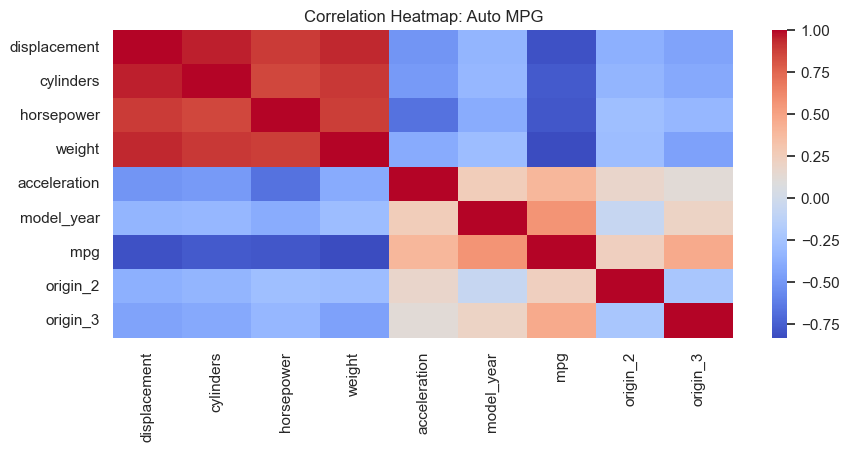

Selected Features: ['weight', 'model_year', 'origin_3', 'origin_2']

--- Statistical Summary (In-Sample) ---
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.2466      4.025     -4.285      0.000     -25.160      -9.333
weight        -0.0060      0.000    -22.966      0.000      -0.007      -0.005
model_year     0.7600      0.049     15.573      0.000       0.664       0.856
origin_3       2.1576      0.514      4.195      0.000       1.146       3.169
origin_2       1.7525      0.520      3.372      0.001       0.730       2.775
In-Sample R-squared: 0.8195
Validation (80-20) R-squared: 0.8111
5-Fold CV Average R-squared: 0.8124


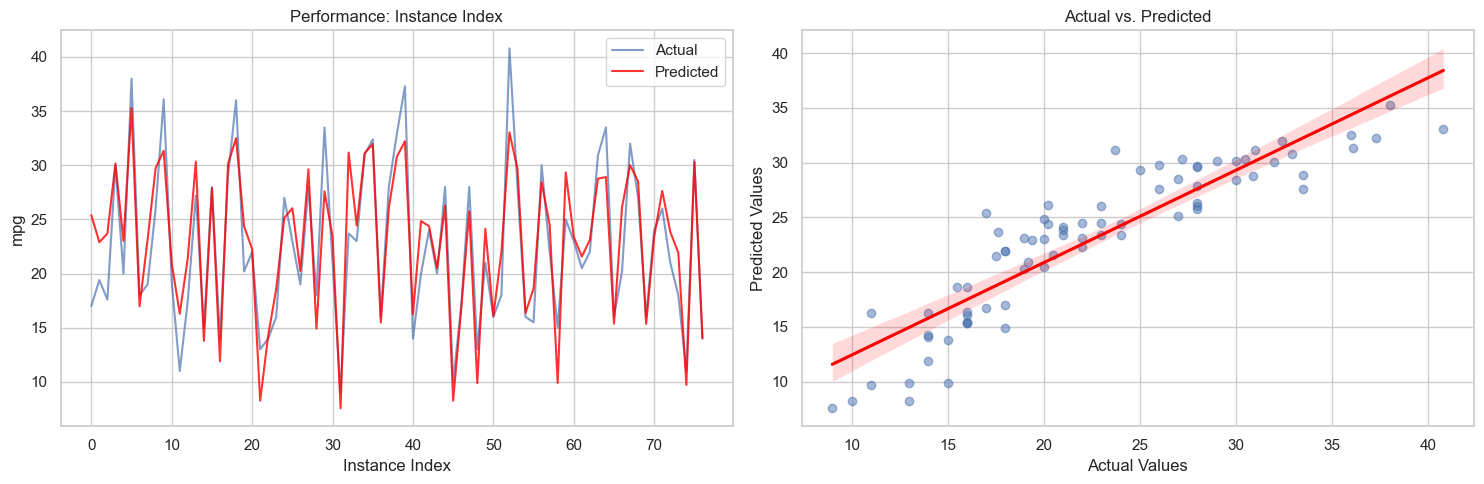

In [8]:
# Load
auto_data = fetch_ucirepo(id=9)
df_auto = pd.concat([auto_data.data.features, auto_data.data.targets], axis=1)

# Specific Cleaning
df_auto['horsepower'] = pd.to_numeric(df_auto['horsepower'], errors='coerce')
df_auto = df_auto.dropna()
df_auto = pd.get_dummies(df_auto, columns=['origin'], drop_first=True, dtype=int) # Encode origin

# Run Pipeline
df_auto = clean_and_outliers(df_auto, 'mpg')
run_full_analysis(df_auto, 'mpg', "Auto MPG")

## Dataset 2: House Price


##############################
ANALYSIS: Home Value Insights
##############################


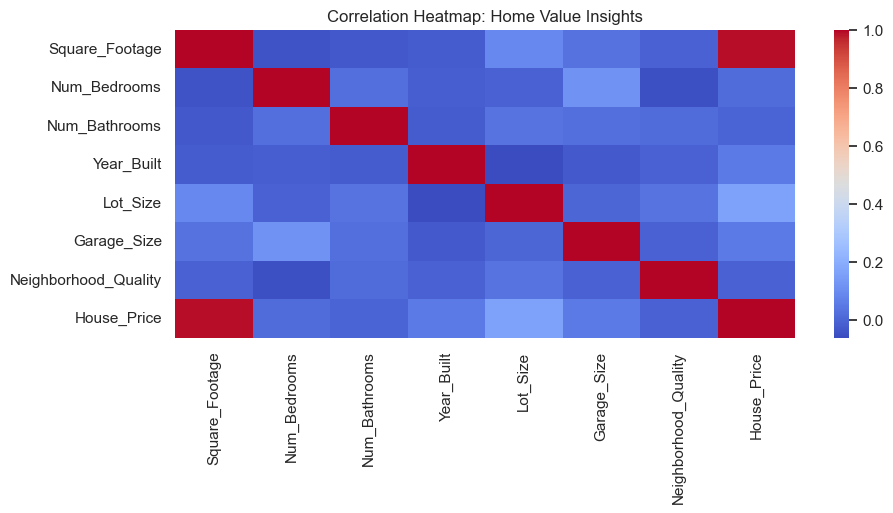

Selected Features: ['Square_Footage', 'Year_Built', 'Lot_Size', 'Num_Bedrooms', 'Num_Bathrooms', 'Garage_Size']

--- Statistical Summary (In-Sample) ---
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.006e+06      3e+04    -66.795      0.000   -2.07e+06   -1.95e+06
Square_Footage   199.7539      0.248    804.027      0.000     199.266     200.241
Year_Built       991.3763     15.061     65.822      0.000     961.821    1020.932
Lot_Size        1.493e+04    240.364     62.098      0.000    1.45e+04    1.54e+04
Num_Bedrooms    1.016e+04    218.849     46.438      0.000    9733.493    1.06e+04
Num_Bathrooms   8249.3476    378.560     21.791      0.000    7506.479    8992.216
Garage_Size     5156.3457    383.258     13.454      0.000    4404.257    5908.435
In-Sample R-squared: 0.9985
Validation (80-20) R-squared: 0.9984
5-Fold CV Average R-squared: 0.9985

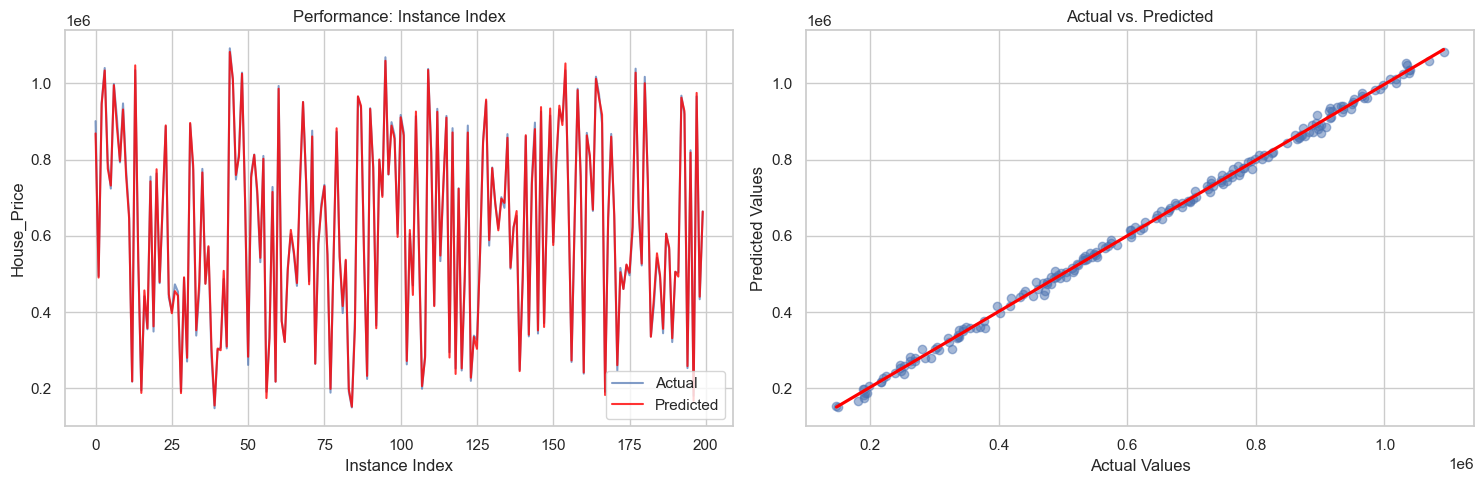

In [9]:
try:
    # Load (assuming file is in current directory)
    df_home = pd.read_csv('data/house_price_regression_dataset.csv')
    
    # Specific Cleaning: Keep only numeric features for linear regression
    df_home = df_home.select_dtypes(include=[np.number])
    
    # Run Pipeline
    df_home = clean_and_outliers(df_home, 'House_Price')
    run_full_analysis(df_home, 'House_Price', "Home Value Insights")
except FileNotFoundError:
    print("Please download house_price_regression_dataset.csv from Kaggle and place it in the data folder.")

## Dataset 3: Parkinson's Telemonitoring


##############################
ANALYSIS: Parkinsons Telemonitoring
##############################


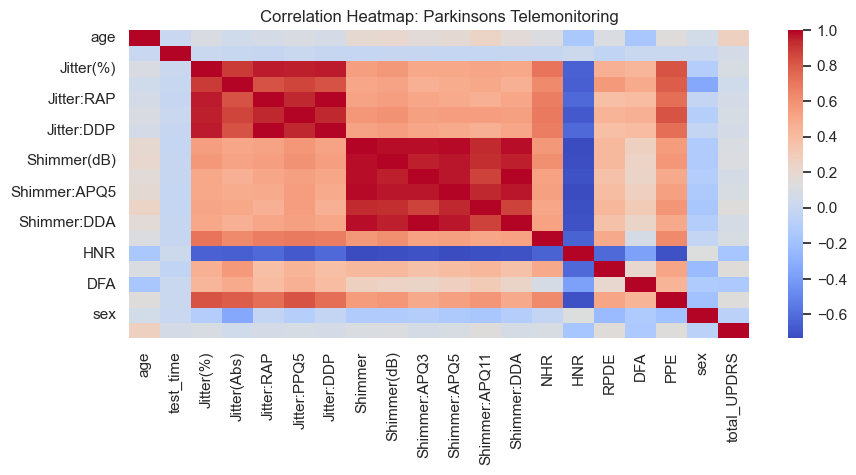

Selected Features: ['age', 'HNR', 'DFA', 'test_time', 'sex', 'Shimmer:APQ3', 'Shimmer:APQ11', 'PPE', 'Jitter(Abs)', 'Jitter:DDP', 'NHR', 'RPDE']

--- Statistical Summary (In-Sample) ---
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            49.5976      3.493     14.200      0.000      42.750      56.445
age               0.2275      0.018     12.840      0.000       0.193       0.262
HNR              -0.7587      0.074    -10.212      0.000      -0.904      -0.613
DFA             -38.0961      2.517    -15.133      0.000     -43.031     -33.161
test_time         0.0178      0.002      7.198      0.000       0.013       0.023
sex              -3.3422      0.365     -9.149      0.000      -4.058      -2.626
Shimmer:APQ3   -367.5587     36.610    -10.040      0.000    -439.328    -295.789
Shimmer:APQ11   186.2305     24.948      7.465      0.000     137.323     23

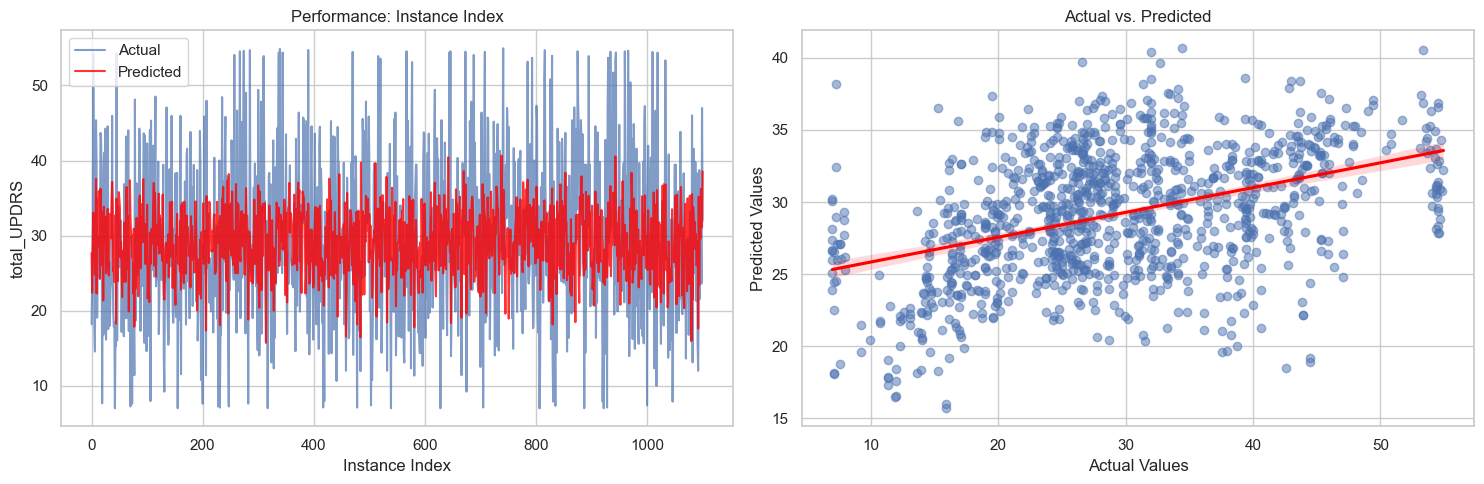

In [10]:
# Load
parkinsons = fetch_ucirepo(id=189)
# We choose 'total_UPDRS' as the target
df_park = pd.concat([parkinsons.data.features, parkinsons.data.targets[['total_UPDRS']]], axis=1)

# Specific Cleaning
if 'subject#' in df_park.columns:
    df_park = df_park.drop(columns=['subject#'])

# Run Pipeline
df_park = clean_and_outliers(df_park, 'total_UPDRS')
run_full_analysis(df_park, 'total_UPDRS', "Parkinsons Telemonitoring")